In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

In [175]:
# curves_df = pd.read_csv('08.09.2022_NYMEX_curves.csv')
# strips_df = pd.read_csv('08.09.2022_NYMEX_strips.csv')

curves_df = pd.read_csv('/root/NYMEX_Charts/08.09.2022_NYMEX_curves.csv')
strips_df = pd.read_csv('/root/NYMEX_Charts/08.09.2022_NYMEX_strips.csv')
curves_df

,TTS,Contract Month,Price,Strip,Trade Date
0,22128366,3/1/2022,5.349,Nov21-Mar22,2/2/2022 21:53
1,22128374,4/1/2022,4.955,Apr22-Oct22,2/2/2022 21:53
2,22128383,5/1/2022,4.944,Apr22-Oct22,2/2/2022 21:53
3,22128391,6/1/2022,4.996,Apr22-Oct22,2/2/2022 21:53
4,22128399,7/1/2022,5.022,Apr22-Oct22,2/2/2022 21:53
...,...,...,...,...,...
128983,89089533,6-01-26,3.826,Apr26-Oct26,2022-08-19 16:00
128984,89089532,7-01-26,4.44,Apr26-Oct26,2022-08-19 16:00
128985,89089534,8-01-26,4.093,Apr26-Oct26,2022-08-19 16:00
128986,89089527,9-01-26,4.32,Apr26-Oct26,2022-08-19 16:00


In [3]:
strips_df

,Strip,Price,Trade Date
0,1,NaN,NaN
1,Apr22-Oct22,4.729714,1/31/2022
2,Apr23-Oct23,3.421714,1/31/2022
3,Apr24-Oct24,3.081143,1/31/2022
4,Apr25-Oct25,2.925143,1/31/2022
...,...,...,...
25778,Apr26-Oct26,4.142714,2022-08-14 16:54
25779,Nov22-Mar23,8.470400,2022-08-14 16:54
25780,Nov23-Mar24,5.481000,2022-08-14 16:54
25781,Nov24-Mar25,5.058800,2022-08-14 16:54


In [82]:
from datetime import datetime
from datetime import date

strips = pd.DataFrame(set(strips_df['Strip']))
strips = strips.rename(columns={0:'Strip',})
strips['From'] = strips['Strip'].str[:5]
strips['To'] = strips['Strip'].str[6:]
strips = strips[strips['Strip']!='1']
strips['From'] = pd.to_datetime(strips['From'],format='%b%y')
strips['To'] = pd.to_datetime(strips['To'],format='%b%y')
strips['Today'] = pd.to_datetime(date.today())
strips['Days Away'] = (strips['To']-strips['Today']).dt.days
strips = strips[strips['Days Away'] > 0]
strips = strips.sort_values(by=['Days Away'])
strips = strips.reset_index()
strips = strips.drop(['index'], axis=1)
strips.loc[strips['Strip'].str[6:9] == 'Oct', 'Season'] = 's' 
strips.loc[strips['Strip'].str[6:9] != 'Oct', 'Season'] = 'w' 

print('The Nearest Strips Available')
strips
# print(strips['Strip'].values.tolist())

The Nearest Strips Available


,Strip,From,To,Today,Days Away,Season
0,Apr22-Oct22,2022-04-01,2022-10-01,2022-08-23,39,s
1,Nov22-Mar23,2022-11-01,2023-03-01,2022-08-23,190,w
2,Apr23-Oct23,2023-04-01,2023-10-01,2022-08-23,404,s
3,Nov23-Mar24,2023-11-01,2024-03-01,2022-08-23,556,w
4,Apr24-Oct24,2024-04-01,2024-10-01,2022-08-23,770,s
5,Nov24-Mar25,2024-11-01,2025-03-01,2022-08-23,921,w
6,Apr25-Oct25,2025-04-01,2025-10-01,2022-08-23,1135,s
7,Nov25-Mar26,2025-11-01,2026-03-01,2022-08-23,1286,w
8,Apr26-Oct26,2026-04-01,2026-10-01,2022-08-23,1500,s


In [98]:
strips_df['Keep'] = strips_df['Strip'].isin(strips['Strip'])
strips_df = strips_df[strips_df['Keep'] == True]
strips_df = strips_df.drop(['Keep'], axis=1)
strips_df['Trade Date'] = strips_df['Trade Date'].str[:9]
strips_df = strips_df.groupby(by=['Trade Date','Strip']).agg({'Price':np.average})
# strips_df = np.round(strips_df['Price'],4)
# strips_df = strips_df.rename(index=None, columns={'Date':'Trade Date'})
strips_df = strips_df.reset_index()
strips_df['Trade Date'] = pd.to_datetime(strips_df['Trade Date'])


days_df = pd.DataFrame(pd.date_range(strips_df['Trade Date'].min(),strips_df['Trade Date'].max(),freq='D'))
days_df = days_df.loc[days_df.index.repeat(len(strips))]
days_df = days_df.reset_index(drop=True)
days_df['Trade Date'] = days_df.iloc[:,0]
days_df = days_df.iloc[: , 1:]
days_df['Strip'] = pd.Series(strips['Strip'].values.tolist()*int(len(days_df)/len(strips)))

strips_df= pd.merge(days_df,strips_df,on=['Trade Date','Strip'],how='outer')


In [176]:
curves_df['Keep'] = curves_df['Strip'].isin(strips['Strip'])
curves_df = curves_df[curves_df['Keep'] == True]
curves_df = curves_df.drop(['Keep'], axis=1)
curves_df['Len'] = curves_df['Trade Date'].map(len)

curves_df['Date'] = curves_df['Trade Date'].str[:9]
curves_df.loc[curves_df['Len']==14, 'Date']= curves_df['Trade Date'].str[:9]
curves_df.loc[curves_df['Len']==16, 'Date']= curves_df['Trade Date'].str[:10]
curves_df = curves_df.drop(['Len'], axis=1)

curves_df['Price'] = curves_df['Price'].astype(float)
# curves_df = curves_df.groupby(by=['Date', 'Contract Month', 'Strip']).agg({'Price':np.average})
# curves_df = np.round(curves_df['Price'],4)

curves_df = curves_df.reset_index()
# days_df
curves_df

# print(days_df.dtypes)
# print(strips_df.dtypes)

,index,TTS,Contract Month,Price,Strip,Trade Date,Date
0,1,22128374,4/1/2022,4.955,Apr22-Oct22,2/2/2022 21:53,2/2/2022
1,2,22128383,5/1/2022,4.944,Apr22-Oct22,2/2/2022 21:53,2/2/2022
2,3,22128391,6/1/2022,4.996,Apr22-Oct22,2/2/2022 21:53,2/2/2022
3,4,22128399,7/1/2022,5.022,Apr22-Oct22,2/2/2022 21:53,2/2/2022
4,5,22128407,8/1/2022,5.026,Apr22-Oct22,2/2/2022 21:53,2/2/2022
...,...,...,...,...,...,...,...
125999,128983,89089533,6-01-26,3.826,Apr26-Oct26,2022-08-19 16:00,2022-08-19
126000,128984,89089532,7-01-26,4.440,Apr26-Oct26,2022-08-19 16:00,2022-08-19
126001,128985,89089534,8-01-26,4.093,Apr26-Oct26,2022-08-19 16:00,2022-08-19
126002,128986,89089527,9-01-26,4.320,Apr26-Oct26,2022-08-19 16:00,2022-08-19


In [6]:
# last_trades = pd.DataFrame(set(curves_df['Trade Date']))
# last_trades = last_trades.sort_values(by=[0])

# last_trades

In [6]:
now_curve = pd.DataFrame(set(curves_df['Contract Month']))
now_curve = now_curve.sort_values(by=[0])

now_curve

,0
77,1-01-23
54,1-01-24
3,1-01-25
30,1-01-26
95,1/1/2023
...,...
42,9/1/2022
0,9/1/2023
98,9/1/2024
72,9/1/2025


In [177]:
# strips_df[strips_df['Strip'].isin(strips['Strip'][0:3])]
curves_df['Date'] = pd.to_datetime(curves_df['Date'])
curves_df

,index,TTS,Contract Month,Price,Strip,Trade Date,Date
0,1,22128374,4/1/2022,4.955,Apr22-Oct22,2/2/2022 21:53,2022-02-02
1,2,22128383,5/1/2022,4.944,Apr22-Oct22,2/2/2022 21:53,2022-02-02
2,3,22128391,6/1/2022,4.996,Apr22-Oct22,2/2/2022 21:53,2022-02-02
3,4,22128399,7/1/2022,5.022,Apr22-Oct22,2/2/2022 21:53,2022-02-02
4,5,22128407,8/1/2022,5.026,Apr22-Oct22,2/2/2022 21:53,2022-02-02
...,...,...,...,...,...,...,...
125999,128983,89089533,6-01-26,3.826,Apr26-Oct26,2022-08-19 16:00,2022-08-19
126000,128984,89089532,7-01-26,4.440,Apr26-Oct26,2022-08-19 16:00,2022-08-19
126001,128985,89089534,8-01-26,4.093,Apr26-Oct26,2022-08-19 16:00,2022-08-19
126002,128986,89089527,9-01-26,4.320,Apr26-Oct26,2022-08-19 16:00,2022-08-19


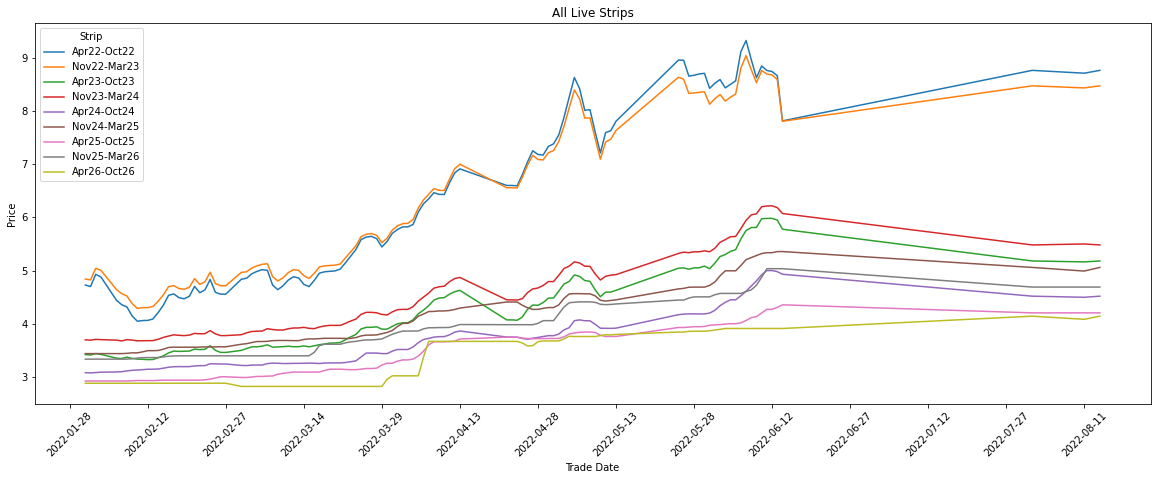

In [9]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig1 = plt.figure(figsize=(20,7))

sp1 = fig1.add_subplot(1,1,1)

# plot 1
sp1 = sns.lineplot(data = strips_df[strips_df['Strip'].isin(strips['Strip'][:])], x='Trade Date', y='Price', hue='Strip').set(title='All Live Strips')
ax = plt.gca()

ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation = 45)

# plot 2
sp2 = 0

# plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis

# ymin, ymax = ax.get_ylim()
# custom_ticks = np.linspace(ymin, ymax, N, dtype=int)
# ax.set_yticks(custom_ticks)
# ax.set_yticklabels(custom_ticks)


# need to change these charts to be daily averages - done
# fill in the empty rows with a straight line

# plt.savefig('fig1.png')
plt.savefig('/root/GitHub/energynewz.github.io/fig1.png')
plt.show()

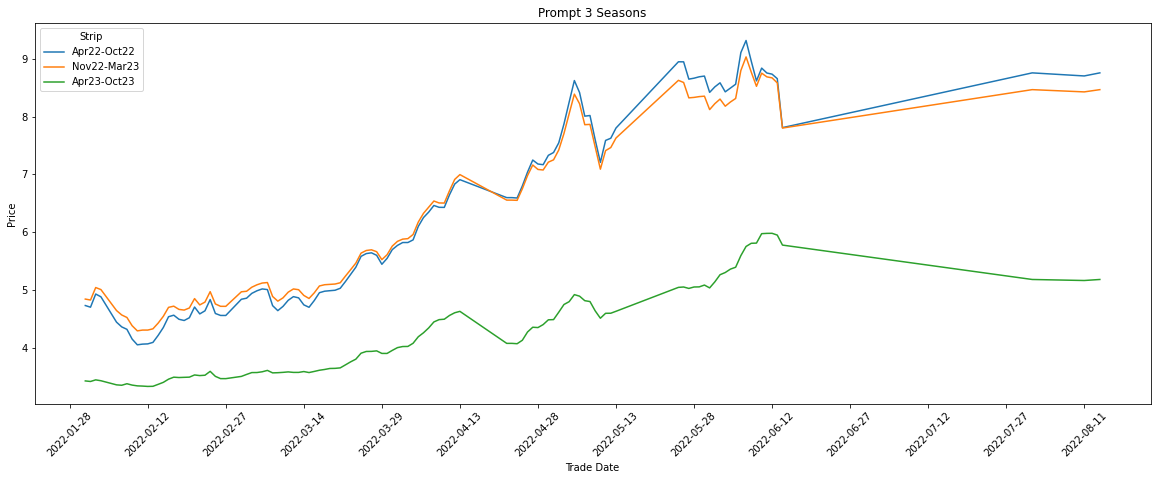

In [10]:
fig2 = plt.figure(figsize=(20,7))

sp1 = fig2.add_subplot(1,1,1)

# plot 1
sp1 = sns.lineplot(data = strips_df[strips_df['Strip'].isin(strips['Strip'][0:3])], x='Trade Date', y='Price', hue='Strip').set(title='Prompt 3 Seasons')
ax = plt.gca()

ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation = 45)

# plot 2
sp2 = 0

# plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis

# ymin, ymax = ax.get_ylim()
# custom_ticks = np.linspace(ymin, ymax, N, dtype=int)
# ax.set_yticks(custom_ticks)
# ax.set_yticklabels(custom_ticks)

# plt.savefig('fig2.png')
plt.savefig("/root/GitHub/energynewz.github.io/fig2.png")
plt.show()

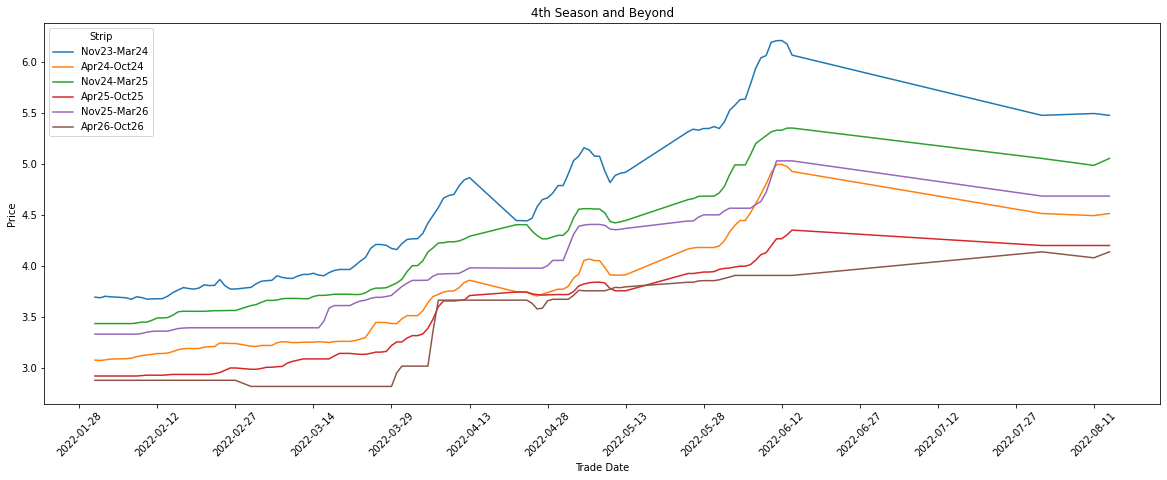

In [11]:
fig3 = plt.figure(figsize=(20,7))

sp1 = fig3.add_subplot(1,1,1)

# plot 1
sp1 = sns.lineplot(data = strips_df[strips_df['Strip'].isin(strips['Strip'][3:])], x='Trade Date', y='Price', hue='Strip').set(title='4th Season and Beyond')
ax = plt.gca()

ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation = 45)

# plot 2
sp2 = 0

# plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis

# ymin, ymax = ax.get_ylim()
# custom_ticks = np.linspace(ymin, ymax, N, dtype=int)
# ax.set_yticks(custom_ticks)
# ax.set_yticklabels(custom_ticks)

# plt.savefig('fig3.png')
plt.savefig("/root/GitHub/energynewz.github.io/fig3.png")
plt.show()

In [179]:
curves_df[curves_df['Trade Date'] == curves_df['Trade Date'].max()]
curves_df['Date'] = pd.to_datetime(curves_df['Date'])
curves_df['Trade Date'] = pd.to_datetime(curves_df['Trade Date'])
curves_df['Contract Month'] = pd.to_datetime(curves_df['Contract Month'])
curves_df = curves_df.sort_values(by=['Trade Date','Contract Month'], ascending=[False, True])
curves_df = curves_df.reset_index(drop=True)
curves_df


,index,TTS,Contract Month,Price,Strip,Trade Date,Date
0,128938,22128415,2022-09-01,9.297,Apr22-Oct22,2022-08-19 16:00:00,2022-08-19
1,128939,22128425,2022-10-01,9.269,Apr22-Oct22,2022-08-19 16:00:00,2022-08-19
2,128940,22128435,2022-11-01,9.351,Nov22-Mar23,2022-08-19 16:00:00,2022-08-19
3,128941,22128444,2022-12-01,9.452,Nov22-Mar23,2022-08-19 16:00:00,2022-08-19
4,128942,26365031,2023-01-01,9.514,Nov22-Mar23,2022-08-19 16:00:00,2022-08-19
...,...,...,...,...,...,...,...
125999,96,89089543,2025-12-01,3.390,Nov25-Mar26,2022-02-02 21:45:00,2022-02-02
126000,97,89088852,2026-01-01,3.533,Nov25-Mar26,2022-02-02 21:45:00,2022-02-02
126001,98,89088850,2026-02-01,3.402,Nov25-Mar26,2022-02-02 21:45:00,2022-02-02
126002,99,89088853,2026-03-01,3.229,Nov25-Mar26,2022-02-02 21:45:00,2022-02-02


2022-08-19 00:00:00


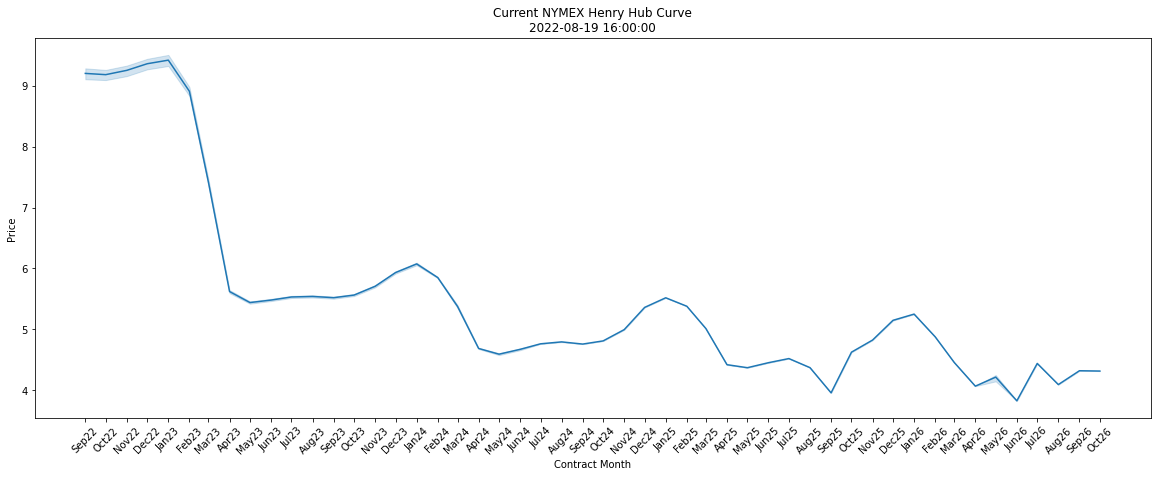

In [180]:
fig4 = plt.figure(figsize=(20,7))

sp5 = fig4.add_subplot(1,1,1)

# plot 1
sp5 = sns.lineplot(data = curves_df[curves_df['Date'] == curves_df['Date'].max()],
                   x='Contract Month',
                   y='Price',
                   sort=True).set(title=str('Current NYMEX Henry Hub Curve\n'+str(curves_df['Trade Date'].max())))

plt.xticks(ticks=(curves_df[curves_df['Trade Date'] == curves_df['Trade Date'].max()]['Contract Month']), labels = curves_df[curves_df['Trade Date'] == curves_df['Trade Date'].max()]['Contract Month'].dt.strftime('%b%y'),rotation = 45)

# plot 2
sp2 = 0

# plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis

# ymin, ymax = ax.get_ylim()
# custom_ticks = np.linspace(ymin, ymax, N, dtype=int)
# ax.set_yticks(custom_ticks)
# ax.set_yticklabels(custom_ticks)
print(curves_df['Date'].max())

# plt.savefig('fig4.png')
plt.savefig("/root/GitHub/energynewz.github.io/fig4.png")
plt.show()

In [172]:
curves_df[curves_df['Trade Date'] == curves_df['Trade Date'].max()]['Contract Month'].dt.strftime('%b%y')


0     Sep22
1     Oct22
2     Nov22
3     Dec22
4     Jan23
5     Feb23
6     Mar23
7     Apr23
8     May23
9     Jun23
10    Jul23
11    Aug23
12    Sep23
13    Oct23
14    Nov23
15    Dec23
16    Jan24
17    Feb24
18    Mar24
19    Apr24
20    May24
21    Jun24
22    Jul24
23    Aug24
24    Sep24
25    Oct24
26    Nov24
27    Dec24
28    Jan25
29    Feb25
30    Mar25
31    Apr25
32    May25
33    Jun25
34    Jul25
35    Aug25
36    Sep25
37    Oct25
38    Nov25
39    Dec25
40    Jan26
41    Feb26
42    Mar26
43    Apr26
44    May26
45    Jun26
46    Jul26
47    Aug26
48    Sep26
49    Oct26
Name: Contract Month, dtype: object

In [ ]:
import datetime
today = datetime.datetime.now()

# wflows_log = pd.read_csv("wflows_log.csv")
wflows_log = pd.read_csv("/root/wflows_log.csv")

update_item = {'Process': ["NYMEX Viz"],
                'Time': [today],
                'Note': ['New Charts']
}
update_item = pd.DataFrame(update_item)

wflows_log = pd.concat([wflows_log,update_item])

# wflows_log.to_csv('wflows_log.csv', index=False)

wflows_log.to_csv("/root/wflows_log.csv", index=False)

In [8]:


today = datetime.datetime.now()
print(today)

2022-08-15 22:48:24.782997
